# Problem Statement
A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

In [139]:
#Load the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import joblib

In [140]:
#Read the file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [141]:
#information on data
train.shape, test.shape

((550068, 12), (233599, 11))

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          161255 non-null  float64
 10  Product_Category_3          71037 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


In [144]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Purchase    233599 non-null  int64 
 1   User_ID     233599 non-null  int64 
 2   Product_ID  233599 non-null  object
dtypes: int64(2), object(1)
memory usage: 5.3+ MB


In [145]:
train.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [146]:
#find the difference in columns between two datasets
train.columns.difference(test.columns)

Index(['Purchase'], dtype='object')

In [147]:
train.columns.difference(sample.columns)

Index(['Age', 'City_Category', 'Gender', 'Marital_Status', 'Occupation',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Stay_In_Current_City_Years'],
      dtype='object')

In [148]:
test.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN


In [149]:
sample.head(2)

,Purchase,User_ID,Product_ID
0,100,1000004,P00128942
1,100,1000009,P00113442


In [150]:
sample.nunique()

Purchase         1
User_ID       5891
Product_ID    3491
dtype: int64

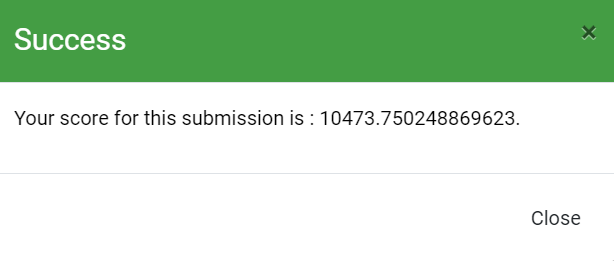

Benchmark

In [151]:
train['Purchase'].nunique()

18105

In [152]:
target_train_mean = int(train['Purchase'].mean())
target_train_mean

9263

In [153]:
sample['Purchase'] = target_train_mean
sample.to_csv('sample_train_mean.csv',index=False)

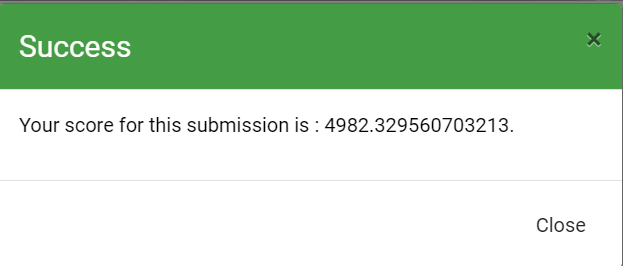

In [154]:
# check for duplicates
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [155]:
#combine the train and test
data = pd.concat([train,test])
train.shape, test.shape, data.shape, train.shape[0] + test.shape[0]

((550068, 12), (233599, 11), (783667, 12), 783667)

In [156]:
data.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

# EDA - univariate

Gender: 75% are male and 25% are female users
Age: Age group 26-35 have top buyers 40% and 0-17 has least buyers
Marital status: 59% are unmarried and 41% are married
City_Category: Category B has most buyers with 42% and A has least buyers with 26%
Product_Category_1: category-5 has high count and category-9 has least

<Axes: ylabel='Gender'>

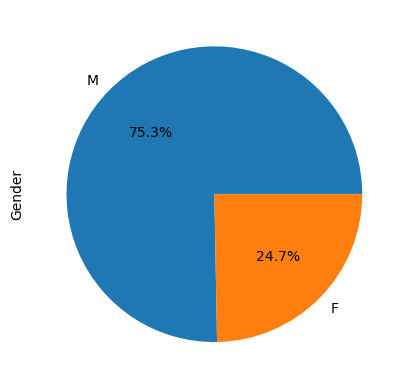

In [157]:
data['Gender'].value_counts().plot.pie(autopct = '%1.1f%%')

In [158]:
data['Age'].unique()

array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'],
      dtype=object)

<Axes: xlabel='Age', ylabel='count'>

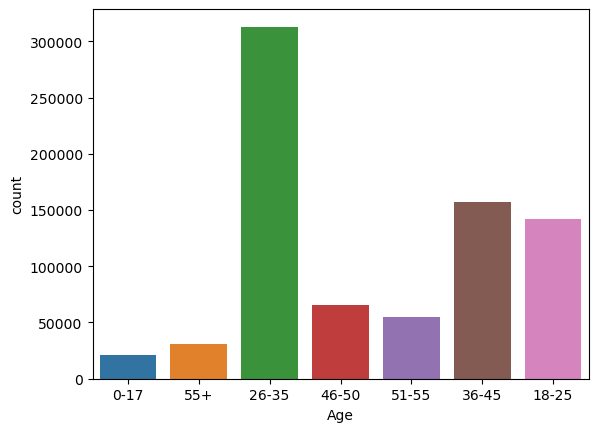

In [44]:
sns.countplot(x= 'Age', data = data)

<Axes: ylabel='Age'>

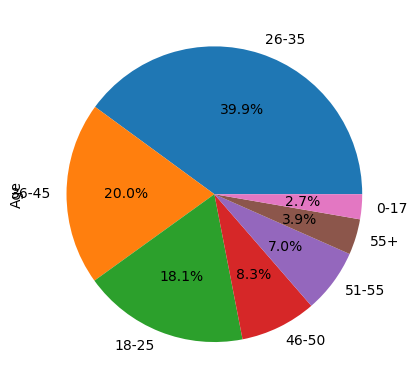

In [159]:
data['Age'].value_counts().plot.pie(autopct= '%1.1f%%')

<Axes: ylabel='Marital_Status'>

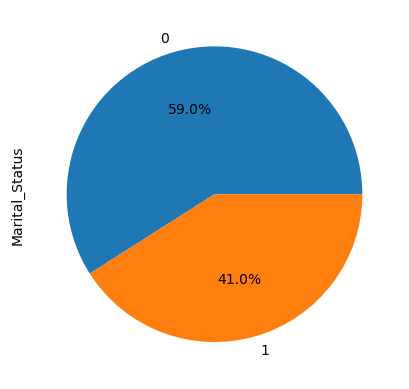

In [160]:
data['Marital_Status'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='City_Category'>

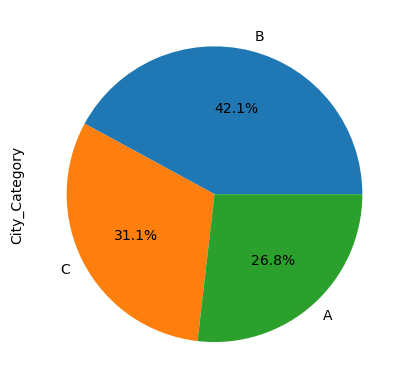

In [161]:
data['City_Category'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: xlabel='Product_Category_1', ylabel='count'>

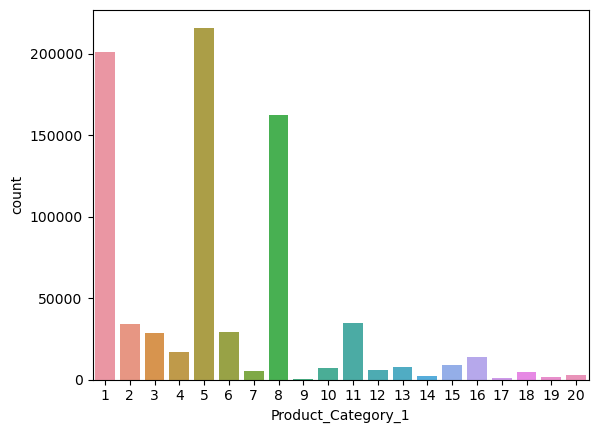

In [162]:
sns.countplot(x = 'Product_Category_1', data = data)

# EDA- Bivariate

Age group 51-55 has highest Purchase

In [163]:
data.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

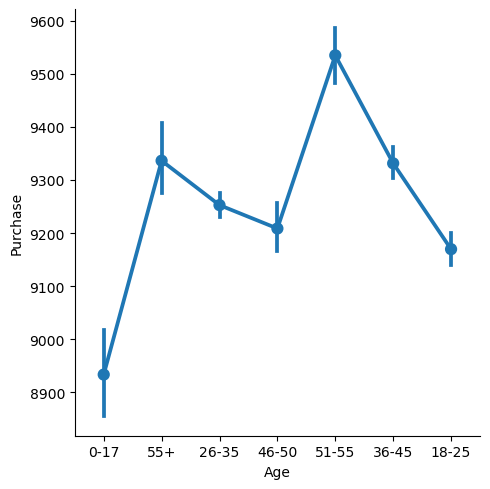

In [164]:
sns.catplot(x='Age', y='Purchase', data = data, kind='point' )

# Preprocessing

In [165]:
data.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            245982
Product_Category_3            545809
Purchase                      233599
dtype: int64

In [166]:
data[['Product_Category_2','Product_Category_3']].isnull().sum()

Product_Category_2    245982
Product_Category_3    545809
dtype: int64

In [167]:
data[['Product_Category_2','Product_Category_3']].isnull().sum().values/data.shape[0]*100

array([31.38858724, 69.64807756])

In [168]:
# Check for unique values
data.nunique()

User_ID                        5891
Product_ID                     3677
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

In [169]:
data['Gender'].unique()

array(['F', 'M'], dtype=object)

In [170]:
# list comprehension
[np.sort(data[i].unique())
for i in data[
['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']].columns]

[array(['F', 'M'], dtype=object),
 array(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
       dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20], dtype=int64),
 array(['A', 'B', 'C'], dtype=object),
 array(['0', '1', '2', '3', '4+'], dtype=object),
 array([0, 1], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20], dtype=int64),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., nan]),
 array([ 3.,  4.,  5.,  6.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
        17., 18., nan])]

### Define Imputation, scaling and Encoding using Pipeline

In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 77.7+ MB


In [172]:
# differentiate category, numerical calumns

cat_cols = data.drop(columns=['User_ID','Product_ID','Purchase']).select_dtypes('object').columns
print(cat_cols)

num_cols = data.drop(columns=['User_ID','Product_ID','Purchase']).select_dtypes(['int','float']).columns
print(num_cols)

Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')
Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object')


In [173]:
#data_cat = data.select_dtypes(exclude = np.number)
#data_cat.columns

In [174]:
# contains pipeline for onehotcoding
cat_encode = Pipeline(steps=[
        ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ])

# contains pipeline for Imputing and Scaling
num_encode = Pipeline(steps=[
        ('simp',SimpleImputer(strategy='mean')),
        ('mms',MinMaxScaler())
    ])


In [175]:
cat_encode, num_encode

(Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))]),
 Pipeline(steps=[('simp', SimpleImputer()), ('mms', MinMaxScaler())]))

In [176]:
full_encode = ColumnTransformer(transformers =[
        ('cat_prep',cat_encode,cat_cols), # run ohe on all categorical cols
        ('num_prep',num_encode,num_cols)  # run imputer+scaling on all numeric cols
    ])

In [177]:
full_encode

ColumnTransformer(transformers=[('cat_prep',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                ('num_prep',
                                 Pipeline(steps=[('simp', SimpleImputer()),
                                                 ('mms', MinMaxScaler())]),
                                 Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))])

In [178]:
pipe = Pipeline([
        ('preprocess',full_encode)
    ])

In [179]:
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_prep',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                                 ('num_prep',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))]))])

In [180]:
pipe.fit(data.drop(columns=['User_ID','Product_ID','Purchase']))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_prep',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                                 ('num_prep',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))]))])

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 77.7+ MB


In [182]:
data.drop(columns=['User_ID','Product_ID','Purchase']).columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object')

In [183]:
# saving the pipeline
joblib.dump(pipe,'preprocess_enc.pkl')

['preprocess_enc.pkl']

In [184]:
# Chk data transform using pipeline

new_data = data.drop(columns=['User_ID','Product_ID','Purchase']).head(1)
new_data

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,F,0-17,10,A,2,0,3,NaN,NaN


In [185]:
# below lines are not used in hackathon (only for deep undestanding)
out_new_data = pipe.transform(new_data)

out_new_data = pd.DataFrame(out_new_data)
#out_new_data

pipe_cat_cols = pipe['preprocess'].transformers_[0][1]['ohe'].get_feature_names_out(cat_cols)
ndcols = np.append(pipe_cat_cols, num_cols)
out_new_data.columns = ndcols
out_new_data

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_A,...,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.105263,0.490282,0.644574


### Add model to pipeline

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [187]:
pipe_enc_mdl = Pipeline([
        ('preprocess',full_encode),
        ('model',LinearRegression())
    ])

In [188]:
X = train.drop(columns=['User_ID','Product_ID','Purchase'])
y = train[['Purchase']]

In [189]:
data.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [190]:
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.2,random_state=42)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((440054, 9), (110014, 9), (440054, 1), (110014, 1))

In [191]:
pipe_enc_mdl.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_prep',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                                 ('num_prep',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [192]:
pred_val_y = pipe_enc_mdl.predict(val_X)
print('Validation RMSE:',mean_squared_error(val_y,pred_val_y,squared=False))

Validation RMSE: 4679.554570996959


In [193]:
# fit the data with full train
# predict with test data
pipe_enc_mdl.fit(X,y)
test_X = test.drop(columns=['User_ID','Product_ID'])
pred_test_y = pipe_enc_mdl.predict(test_X)

In [194]:
sample['Purchase'] = pred_test_y
sample.to_csv('sample_pipe_LR.csv',index=False)

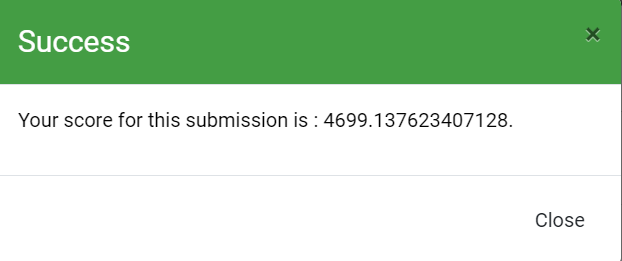

In [195]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

In [200]:
params = {'model': [Ridge(), Lasso()],
          'model__alpha': [.5,3],
          #'model__normalize': [True,False]
         }

In [201]:
grid = GridSearchCV(estimator=pipe_enc_mdl, param_grid=params, scoring='neg_mean_squared_error', cv =2, verbose=0)


In [202]:
grid.fit(train_X, train_y)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_prep',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                                                        ('num_prep',
                                                                         Pipeline(steps=[('simp',
                                                                                          SimpleImputer()),
                                                                                         ('mms',
                                                                                          MinMaxScaler())]),
                                                                         Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))])),
                                       ('model', LinearRegression())]),
             param_grid={'model': [Ridge(), Lasso(alpha=0.5)],
                         'model__alpha': [0.5, 3]},
             scoring='neg_mean_squared_error')

In [131]:
import sklearn
sklearn.__version__

'1.3.0'

In [203]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_prep',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')),
                                                 ('num_prep',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object'))])),
           

In [204]:
final_model = grid.best_estimator_

In [205]:
fin_pred_y = final_model.predict(test_X)

In [206]:
sample['Purchase'] = fin_pred_y
sample.to_csv('sample_pipe_grid_ridge.csv',index=False)

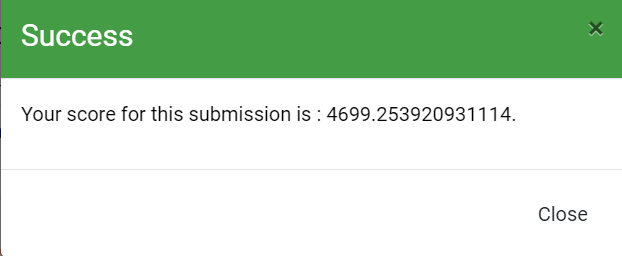